<a href="https://colab.research.google.com/github/Ayush310803/ViT/blob/main/FastSCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install torch torchvision ultralytics opencv-python numpy tensorflow

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import numpy as np
import yaml
from ultralytics import YOLO

In [11]:
results = YOLO("yolov8n-seg.pt").train(data="coco8-seg.yaml", epochs=1, imgsz=640)

with open("datasets/coco8-seg", "r") as file:
    data_cfg = yaml.safe_load(file)

train_images_path = data_cfg["train"]
train_labels_path = data_cfg["val"]


Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=coco8-seg.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

train: Scanning /content/datasets/coco8-seg/labels/train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/coco8-seg/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]


Plotting labels to runs/segment/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/segment/train4
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      1.112      3.105      2.781      1.375         23        640: 100%|██████████| 1/1 [00:07<00:00,  7.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


                   all          4         17      0.696      0.633       0.75      0.491       0.66      0.533      0.611      0.442

1 epochs completed in 0.008 hours.
Optimizer stripped from runs/segment/train4/weights/last.pt, 7.1MB
Optimizer stripped from runs/segment/train4/weights/best.pt, 7.1MB

Validating runs/segment/train4/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv8n-seg summary (fused): 85 layers, 3,404,320 parameters, 0 gradients, 12.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


                   all          4         17      0.699      0.633       0.75      0.491      0.662      0.533      0.611      0.442
                person          3         10      0.551        0.8      0.689      0.323      0.482        0.7      0.597      0.264
                   dog          1          1      0.796          1      0.995      0.796      0.796          1      0.995      0.895
                 horse          1          2      0.299          1      0.995      0.394       0.15        0.5      0.251        0.1
              elephant          1          2          1          0       0.58      0.348          1          0       0.58      0.348
              umbrella          1          1      0.545          1      0.995      0.895      0.545          1      0.995      0.895
          potted plant          1          1          1          0      0.249      0.189          1          0      0.249      0.149
Speed: 2.8ms preprocess, 359.0ms inference, 0.0ms loss, 2.5ms postpro

IsADirectoryError: [Errno 21] Is a directory: 'datasets/coco8-seg'

In [12]:
class FastSCNN(nn.Module):
    def __init__(self, num_classes=80):
        super(FastSCNN, self).__init__()

        self.downsample = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

        self.segmentation_head = nn.Conv2d(256, num_classes, 1)

    def forward(self, x):
        x = self.downsample(x)
        x = self.feature_extractor(x)
        x = self.segmentation_head(x)
        return x


In [13]:
class YoloSegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx].replace(".jpg", ".png"))

        print(f"Image path: {img_path}")
        print(f"Mask path: {label_path}")

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Error: Image at {img_path} could not be loaded.")
        if mask is None:
            print(f"Error: Mask at {label_path} could not be loaded.")

        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 1024)),
    transforms.ToTensor(),
])

train_dataset = YoloSegmentationDataset(train_images_path, train_labels_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FastSCNN(num_classes=80).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}")

torch.save(model.state_dict(), "fast_scnn_yolo.pth")


Image path: /content/datasets/coco8-seg/images/train/000000000034.jpg
Mask path: /content/datasets/coco8-seg/labels/train/000000000034.png
Error: Mask at /content/datasets/coco8-seg/labels/train/000000000034.png could not be loaded.


TypeError: 'NoneType' object cannot be interpreted as an integer

In [ ]:
!ls /content/datasets/coco128-seg

In [15]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F

class FastSCNN(nn.Module):
    def __init__(self, num_classes=80):
        super(FastSCNN, self).__init__()

        self.downsample = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

        self.segmentation_head = nn.Conv2d(256, num_classes, 1)

    def forward(self, x):
        x = self.downsample(x)
        x = self.feature_extractor(x)
        x = self.segmentation_head(x)
        x = F.interpolate(x, size=(512, 1024), mode='bilinear', align_corners=False)
        return x

class YoloSegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, img_size=(512, 1024)):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = os.listdir(image_dir)
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx].replace(".jpg", ".txt"))

        print(f"Image path: {img_path}")
        print(f"Mask path: {label_path}")

        image = cv2.imread(img_path)
        if image is None:
            print(f"Error: Image at {img_path} could not be loaded.")
            return self.__getitem__((idx + 1) % len(self))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)

        mask = np.zeros(self.img_size, dtype=np.uint8)

        try:
            with open(label_path, "r") as file:
                lines = file.readlines()
                for line in lines:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    polygon = np.array([float(x) for x in parts[1:]], dtype=np.float32)
                    polygon = polygon.reshape(-1, 2)

                    polygon[:, 0] *= self.img_size[1]
                    polygon[:, 1] *= self.img_size[0]
                    polygon = polygon.astype(np.int32)

                    cv2.fillPoly(mask, [polygon], color=class_id + 1)
        except FileNotFoundError:
            print(f"Error: Mask file at {label_path} not found.")
            return self.__getitem__((idx + 1) % len(self))

        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 1024)),
    transforms.ToTensor(),
])

train_images_path = "/content/datasets/coco8-seg/images/train"
train_labels_path = "/content/datasets/coco8-seg/labels/train"

train_dataset = YoloSegmentationDataset(train_images_path, train_labels_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FastSCNN(num_classes=80).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}")

torch.save(model.state_dict(), "fast_scnn_coco8seg.pth")

Image path: /content/datasets/coco8-seg/images/train/000000000009.jpg
Mask path: /content/datasets/coco8-seg/labels/train/000000000009.txt
Image path: /content/datasets/coco8-seg/images/train/000000000034.jpg
Mask path: /content/datasets/coco8-seg/labels/train/000000000034.txt
Image path: /content/datasets/coco8-seg/images/train/000000000030.jpg
Mask path: /content/datasets/coco8-seg/labels/train/000000000030.txt
Image path: /content/datasets/coco8-seg/images/train/000000000025.jpg
Mask path: /content/datasets/coco8-seg/labels/train/000000000025.txt
Epoch 1/50, Loss: 4.3932414054870605
Image path: /content/datasets/coco8-seg/images/train/000000000025.jpg
Mask path: /content/datasets/coco8-seg/labels/train/000000000025.txt
Image path: /content/datasets/coco8-seg/images/train/000000000030.jpg
Mask path: /content/datasets/coco8-seg/labels/train/000000000030.txt
Image path: /content/datasets/coco8-seg/images/train/000000000009.jpg
Mask path: /content/datasets/coco8-seg/labels/train/0000000

In [16]:
model.eval()

FastSCNN(
  (downsample): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (feature_extractor): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (segmentation_head): Conv2d(256, 80, kernel_size=(1, 1), stride=(1, 1))
)

Image path: /content/datasets/coco8-seg/images/val/000000000061.jpg
Mask path: /content/datasets/coco8-seg/labels/val/000000000061.txt
Image path: /content/datasets/coco8-seg/images/val/000000000049.jpg
Mask path: /content/datasets/coco8-seg/labels/val/000000000049.txt
Image path: /content/datasets/coco8-seg/images/val/000000000036.jpg
Mask path: /content/datasets/coco8-seg/labels/val/000000000036.txt
Image path: /content/datasets/coco8-seg/images/val/000000000042.jpg
Mask path: /content/datasets/coco8-seg/labels/val/000000000042.txt


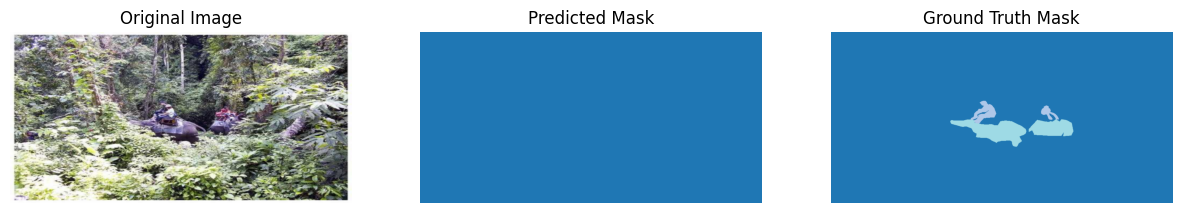

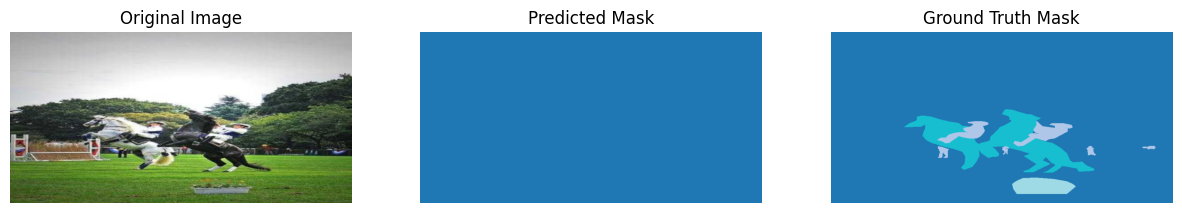

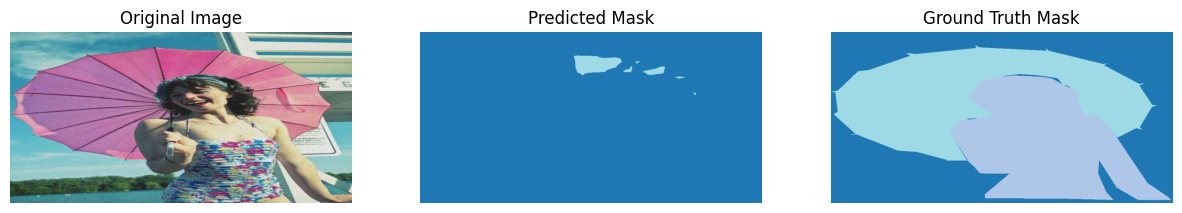

Validation Loss: 4.0171613693237305, Validation Accuracy: 76.91097259521484


In [17]:
val_images_path = "/content/datasets/coco8-seg/images/val"
val_labels_path = "/content/datasets/coco8-seg/labels/val"
val_dataset = YoloSegmentationDataset(val_images_path, val_labels_path, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

model = FastSCNN(num_classes=80).to(device)
model.load_state_dict(torch.load("fast_scnn_coco8seg.pth"))
model.eval()

def validate_model(model, val_loader, criterion, device, num_samples=3):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(val_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += masks.size(0) * masks.size(1) * masks.size(2)
            correct += (predicted == masks).sum().item()

            if batch_idx == 0:
                for i in range(min(num_samples, images.size(0))):
                    original_image = images[i].cpu().numpy().transpose(1, 2, 0)
                    original_image = (original_image * 255).astype(np.uint8)

                    predicted_mask = predicted[i].cpu().numpy()
                    ground_truth_mask = masks[i].cpu().numpy()
                    visualize_results(original_image, predicted_mask, ground_truth_mask)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

def visualize_results(original_image, predicted_mask, ground_truth_mask):
    cmap = plt.get_cmap('tab20')

    predicted_mask_rgb = (cmap(predicted_mask)[:, :, :3] * 255).astype(np.uint8)
    ground_truth_mask_rgb = (cmap(ground_truth_mask)[:, :, :3] * 255).astype(np.uint8)

    if original_image.shape[:2] != predicted_mask.shape:
        predicted_mask_rgb = cv2.resize(predicted_mask_rgb, (original_image.shape[1], original_image.shape[0]))
        ground_truth_mask_rgb = cv2.resize(ground_truth_mask_rgb, (original_image.shape[1], original_image.shape[0]))

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask_rgb)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Ground Truth Mask")
    plt.imshow(ground_truth_mask_rgb)
    plt.axis("off")

    plt.show()

val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

In [18]:
!pip install tensorflow

In [19]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, BatchNormalization, Activation, UpSampling2D, AveragePooling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

def conv_block(inputs, conv_type, kernel, kernel_size, strides, padding='same', relu=True):
    if conv_type == 'ds':
        x = SeparableConv2D(kernel, kernel_size, padding=padding, strides=strides)(inputs)
    else:
        x = Conv2D(kernel, kernel_size, padding=padding, strides=strides)(inputs)
    x = BatchNormalization()(x)
    if relu:
        x = Activation('relu')(x)
    return x

def _res_bottleneck(inputs, filters, kernel, t, s, r=False):
    tchannel = tf.keras.backend.int_shape(inputs)[-1] * t
    x = conv_block(inputs, 'conv', tchannel, (1, 1), strides=(1, 1))
    x = tf.keras.layers.DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv_block(x, 'conv', filters, (1, 1), strides=(1, 1), padding='same', relu=False)
    if r:
        x = tf.keras.layers.add([x, inputs])
    return x

def bottleneck_block(inputs, filters, kernel, t, strides, n):
    x = _res_bottleneck(inputs, filters, kernel, t, strides)
    for i in range(1, n):
        x = _res_bottleneck(x, filters, kernel, t, 1, True)
    return x

def pyramid_pooling_block(input_tensor, bin_sizes):
    concat_list = [input_tensor]
    w, h = input_tensor.shape[1], input_tensor.shape[2]
    for bin_size in bin_sizes:
        x = AveragePooling2D(pool_size=(w // bin_size, h // bin_size), strides=(w // bin_size, h // bin_size))(input_tensor)
        x = Conv2D(128, 3, 2, padding='same')(x)
        x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (w, h)))(x)
        concat_list.append(x)
    return concatenate(concat_list)

def build_fast_scnn(input_shape=(512, 1024, 3), num_classes=80):
    input_layer = Input(shape=input_shape, name='input_layer')

    lds_layer = conv_block(input_layer, 'conv', 32, (3, 3), strides=(2, 2))
    lds_layer = conv_block(lds_layer, 'ds', 48, (3, 3), strides=(2, 2))
    lds_layer = conv_block(lds_layer, 'ds', 64, (3, 3), strides=(2, 2))

    gfe_layer = bottleneck_block(lds_layer, 64, (3, 3), t=6, strides=2, n=3)
    gfe_layer = bottleneck_block(gfe_layer, 96, (3, 3), t=6, strides=2, n=3)
    gfe_layer = bottleneck_block(gfe_layer, 128, (3, 3), t=6, strides=1, n=3)
    gfe_layer = pyramid_pooling_block(gfe_layer, [2, 4, 6, 8])

    ff_layer1 = conv_block(lds_layer, 'conv', 128, (1, 1), strides=(1, 1), relu=False)
    ff_layer2 = UpSampling2D((4, 4))(gfe_layer)
    ff_layer2 = SeparableConv2D(128, (3, 3), padding='same', strides=(1, 1), dilation_rate=(4, 4))(ff_layer2)
    ff_layer2 = BatchNormalization()(ff_layer2)
    ff_layer2 = Activation('relu')(ff_layer2)
    ff_layer2 = Conv2D(128, 1, 1, padding='same', activation=None)(ff_layer2)
    ff_final = tf.keras.layers.add([ff_layer1, ff_layer2])
    ff_final = BatchNormalization()(ff_final)
    ff_final = Activation('relu')(ff_final)

    classifier = SeparableConv2D(128, (3, 3), padding='same', strides=(1, 1))(ff_final)
    classifier = BatchNormalization()(classifier)
    classifier = Activation('relu')(classifier)
    classifier = SeparableConv2D(128, (3, 3), padding='same', strides=(1, 1))(classifier)
    classifier = BatchNormalization()(classifier)
    classifier = Activation('relu')(classifier)
    classifier = conv_block(classifier, 'conv', num_classes, (1, 1), strides=(1, 1), relu=False)
    classifier = Dropout(0.3)(classifier)
    classifier = UpSampling2D((8, 8))(classifier)
    classifier = Activation('softmax')(classifier)

    model1 = Model(inputs=input_layer, outputs=classifier, name='Fast_SCNN')
    return model1

class YoloSegmentationDataset(tf.keras.utils.Sequence):
    def __init__(self, image_dir, label_dir, transform=None, img_size=(512, 1024)):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = os.listdir(image_dir)
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx].replace(".jpg", ".txt"))

        image = cv2.imread(img_path)
        if image is None:
            print(f"Error: Image at {img_path} could not be loaded.")
            return self.__getitem__((idx + 1) % len(self))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)

        mask = np.zeros(self.img_size, dtype=np.uint8)

        try:
            with open(label_path, "r") as file:
                lines = file.readlines()
                for line in lines:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    polygon = np.array([float(x) for x in parts[1:]], dtype=np.float32)
                    polygon = polygon.reshape(-1, 2)

                    polygon[:, 0] *= self.img_size[1]
                    polygon[:, 1] *= self.img_size[0]
                    polygon = polygon.astype(np.int32)

                    cv2.fillPoly(mask, [polygon], color=class_id + 1)
        except FileNotFoundError:
            print(f"Error: Mask file at {label_path} not found.")
            return self.__getitem__((idx + 1) % len(self))

        if self.transform:
            image = self.transform(image)
            mask = tf.convert_to_tensor(mask, dtype=tf.int32)

        return image, mask

def transform(image):
    image = tf.image.resize(image, (512, 1024))
    image = tf.cast(image, tf.float32) / 255.0
    return image

def validate_model(model, val_loader, criterion=None, device=None, num_samples=3):
    model1.evaluate(val_loader)
    val_loss, val_accuracy = model.evaluate(val_loader)
    return val_loss, val_accuracy

train_images_path = "/content/datasets/coco8-seg/images/train"
train_labels_path = "/content/datasets/coco8-seg/labels/train"
val_images_path = "/content/datasets/coco8-seg/images/val"
val_labels_path = "/content/datasets/coco8-seg/labels/val"

train_dataset = YoloSegmentationDataset(train_images_path, train_labels_path, transform=transform)
val_dataset = YoloSegmentationDataset(val_images_path, val_labels_path, transform=transform)

train_loader = tf.data.Dataset.from_generator(
    lambda: train_dataset,
    output_signature=(
        tf.TensorSpec(shape=(512, 1024, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(512, 1024), dtype=tf.int32)
    )
).batch(4)

val_loader = tf.data.Dataset.from_generator(
    lambda: val_dataset,
    output_signature=(
        tf.TensorSpec(shape=(512, 1024, 3),dtype=tf.float32),
        tf.TensorSpec(shape=(512, 1024), dtype=tf.int32)
    )
).batch(4)

model1 = build_fast_scnn(input_shape=(512, 1024, 3), num_classes=80)
optimizer = SGD(learning_rate=0.045, momentum=0.9)
model1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs = 50
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for batch_idx, (images, masks) in enumerate(train_loader):
        with tf.GradientTape() as tape:
            outputs = model1(images, training=True)
            loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(masks, outputs))
        gradients = tape.gradient(loss, model1.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model1.trainable_variables))

        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.numpy()}")

    val_loss, val_accuracy = validate_model(model1, val_loader)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

model1.save("fast_scnn_coco8seg.h5")

Epoch 1/50
Batch 0, Loss: 5.0044050216674805
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.7740 - loss: 4.3553


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.7740 - loss: 4.3553
Validation Loss: 4.355348587036133, Validation Accuracy: 0.7740144729614258
Epoch 2/50
Batch 0, Loss: 4.596044540405273
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7740 - loss: 4.3064
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7740 - loss: 4.3064
Validation Loss: 4.306381702423096, Validation Accuracy: 0.7740144729614258
Epoch 3/50
Batch 0, Loss: 4.3306450843811035
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.7740 - loss: 4.2376
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.7740 - loss: 4.2376
Validation Loss: 4.237630844116211, Validation Accuracy: 0.7740144729614258
Epoch 4/50
Batch 0, Loss: 4.086246967315674
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.7740 - loss: 4.1509
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.7740 - loss: 4.1509
Validation Loss: 4.150909423828125, Validation Accuracy: 0.7740144729614258
Epoch 5/50
Batch 0, Loss: 3.84944224357605
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s

Validation Loss: 1.5116913318634033, Validation Accuracy: 0.7740144729614258
